<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/RL_01_05(policy_based).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

관측 차원: 4
행동 개수: 2
🚀 훈련 시작...
EP 010 | Return 13.0 | Epsilon 0.951
EP 020 | Return 12.0 | Epsilon 0.905
EP 030 | Return 36.0 | Epsilon 0.860
EP 040 | Return 83.0 | Epsilon 0.818
EP 050 | Return 41.0 | Epsilon 0.778
EP 060 | Return 25.0 | Epsilon 0.740
EP 070 | Return 18.0 | Epsilon 0.704
EP 080 | Return 50.0 | Epsilon 0.670
EP 090 | Return 16.0 | Epsilon 0.637
EP 100 | Return 92.0 | Epsilon 0.606
EP 110 | Return 61.0 | Epsilon 0.576
EP 120 | Return 86.0 | Epsilon 0.548
EP 130 | Return 21.0 | Epsilon 0.521
EP 140 | Return  9.0 | Epsilon 0.496
EP 150 | Return 27.0 | Epsilon 0.471
EP 160 | Return 24.0 | Epsilon 0.448
EP 170 | Return 58.0 | Epsilon 0.427
EP 180 | Return 48.0 | Epsilon 0.406
EP 190 | Return 16.0 | Epsilon 0.386
EP 200 | Return 42.0 | Epsilon 0.367
EP 210 | Return 64.0 | Epsilon 0.349
EP 220 | Return 44.0 | Epsilon 0.332
EP 230 | Return 96.0 | Epsilon 0.316
EP 240 | Return 28.0 | Epsilon 0.300
EP 250 | Return 15.0 | Epsilon 0.286
EP 260 | Return 13.0 | Epsilon 0.272
EP 270 | 

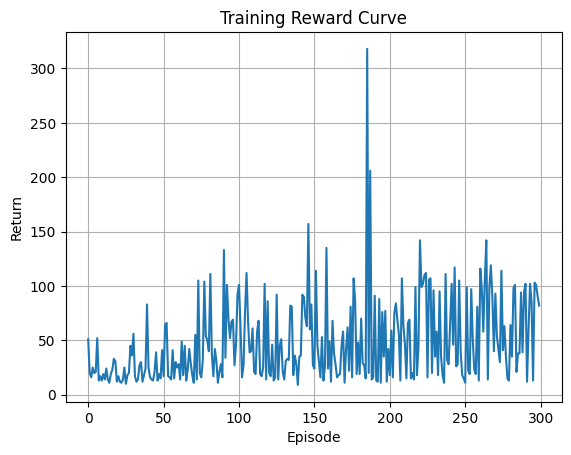

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/cartpole_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/cartpole_videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/cartpole_videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole_videos/rl-video-episode-0.mp4
🎬 비디오 파일: cartpole_videos/rl-video-episode-0.mp4


In [ ]:
# ================================================
# 🎥 CartPole DQN with Visualization (Working Video Playback)
# ================================================

!pip install -q gymnasium[classic-control]==0.29.1

import numpy as np
import collections
import random
import matplotlib.pyplot as plt

import gymnasium as gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, display
import os

# ---------- 1) 환경 생성 ----------
env = gym.make("CartPole-v1")

obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
print("관측 차원:", obs_dim)
print("행동 개수:", n_actions)

# ---------- 2) Q-Network ----------
def create_q_net():
    model = keras.Sequential([
        layers.Input(shape=(obs_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(n_actions)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

q_net = create_q_net()
target_q_net = create_q_net()
target_q_net.set_weights(q_net.get_weights())

# ---------- 3) Replay Buffer ----------
Transition = collections.namedtuple("Transition", ["s","a","r","ns","d"])
buffer = collections.deque(maxlen=50000)

# ---------- 4) ε-greedy 정책 ----------
def select_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    q = q_net(tf.convert_to_tensor(state[None, :], tf.float32))
    return int(tf.argmax(q[0]))

# ---------- 5) 학습 함수 ----------
@tf.function
def train_step(states, actions, rewards, next_states, dones):
    states_tf = tf.convert_to_tensor(states, tf.float32)
    next_states_tf = tf.convert_to_tensor(next_states, tf.float32)
    actions_tf = tf.convert_to_tensor(actions, tf.int32)
    rewards_tf = tf.convert_to_tensor(rewards, tf.float32)
    dones_tf = tf.convert_to_tensor(dones, tf.float32)

    next_q = target_q_net(next_states_tf)
    max_next_q = tf.reduce_max(next_q, axis=1)
    target_values = rewards_tf + 0.99 * max_next_q * (1-dones_tf)

    with tf.GradientTape() as tape:
        q_values = q_net(states_tf)
        idx = tf.stack([tf.range(tf.shape(actions_tf)[0]), actions_tf], axis=1)
        chosen_q = tf.gather_nd(q_values, idx)
        loss = tf.reduce_mean((target_values - chosen_q)**2)

    grads = tape.gradient(loss, q_net.trainable_variables)
    q_net.optimizer.apply_gradients(zip(grads, q_net.trainable_variables))


# ---------- 6) 학습 루프 ----------
returns = []
epsilon = 1.0

print("🚀 훈련 시작...")
state, _ = env.reset()
while len(buffer) < 1000:
    a = env.action_space.sample()
    ns, r, term, trunc, _ = env.step(a)
    buffer.append(Transition(state,a,r,ns,term or trunc))
    state = ns
    if term or trunc:
        state,_ = env.reset()

for ep in range(1, 301):
    state,_ = env.reset()
    total = 0

    for t in range(500):
        a = select_action(state, epsilon)
        ns, r, term, trunc, _ = env.step(a)
        buffer.append(Transition(state,a,r,ns,term or trunc))
        state = ns
        total += r

        batch = random.sample(buffer, 64)
        b_s = np.array([x.s for x in batch])
        b_a = np.array([x.a for x in batch], dtype=np.int32)
        b_r = np.array([x.r for x in batch], dtype=np.float32)
        b_ns = np.array([x.ns for x in batch])
        b_d = np.array([x.d for x in batch], dtype=np.float32)
        train_step(b_s,b_a,b_r,b_ns,b_d)

        if term or trunc:
            break

    epsilon = max(0.01, epsilon*0.995)
    returns.append(total)

    if ep % 10 == 0:
        target_q_net.set_weights(q_net.get_weights())
        print(f"EP {ep:03d} | Return {total:4.1f} | Epsilon {epsilon:.3f}")

# ---------- 7) 학습 결과 곡선 ----------
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Training Reward Curve")
plt.grid(True)
plt.show()


# ---------- 8) 🎥 확실한 비디오 녹화 ----------
video_folder = "cartpole_videos/"
if not os.path.exists(video_folder):
    os.makedirs(video_folder)

eval_env = RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder,
    episode_trigger=lambda x: True  # 첫 평가 에피소드만 녹화
)

state, _ = eval_env.reset()
done = False
while not done:
    q = q_net(tf.convert_to_tensor(state[None,:],tf.float32))
    action = int(tf.argmax(q[0]))
    next_state, reward, terminated, truncated, _ = eval_env.step(action)
    done = terminated or truncated
    state = next_state

eval_env.close()

# 최신 비디오 파일 자동 재생
videos = sorted(os.listdir(video_folder))
last_video_path = os.path.join(video_folder, videos[-1])
print("🎬 비디오 파일:", last_video_path)

display(Video(last_video_path, embed=True))
